Author: Elizabeth Luong

Date: January 22, 2025

## Q1
 
\begin{align*}
\text{Likelihood} && p(x|\theta, n) &={} \binom{n}{x} \theta^x (1-\theta)^{n-x} \quad \text{(Binomial)} \\\\
\text{Prior} && p(\theta) &={} 
\begin{cases} 
\frac{1}{101} & \text{for } \theta = \frac{i}{100}, \; i = 0, 1, \cdots, 100 \\\\
0 & \text{otherwise}
\end{cases} \quad \text{(Discrete Uniform)} \\\\
\text{Posterior} && p(\theta|x, n) &={} 
\overset{\text{Bayes Theorem}}{\frac{p(x|\theta)p(\theta)}{p(x)}} \\\\
&&& \quad\quad = \frac{\binom{n}{x} \theta^x (1-\theta)^{n-x} \cdot \frac{1}{101}}{p(x)} \quad \text{(Substitute Likelihood and Prior)} \\\\
&&& \quad\quad = \frac{\theta^x (1-\theta)^{n-x}}{\sum_{i=0}^{100} \left(\frac{i}{100}\right)^x \left(1 - \frac{i}{100}\right)^{n-x}} \quad \text{(Normalize Over Support)} \\\\
&&& \quad\quad = \text{Discrete Beta Distribution} \\\\
&&& \quad\quad\quad\quad\quad\; = \text{With parameters x+1 (successes) and n-x+1(failures).} \\\\
\end{align*}

### The posterior is always proportional to the joint

$$\large p(\theta|x, n) =\propto{} \theta^x (1-\theta)^{n-x}$$

**and the posterior is always a proper distribution if the prior is a proper distribution, meaning that the prior integrates (or sums) to 1.** 


## Q2

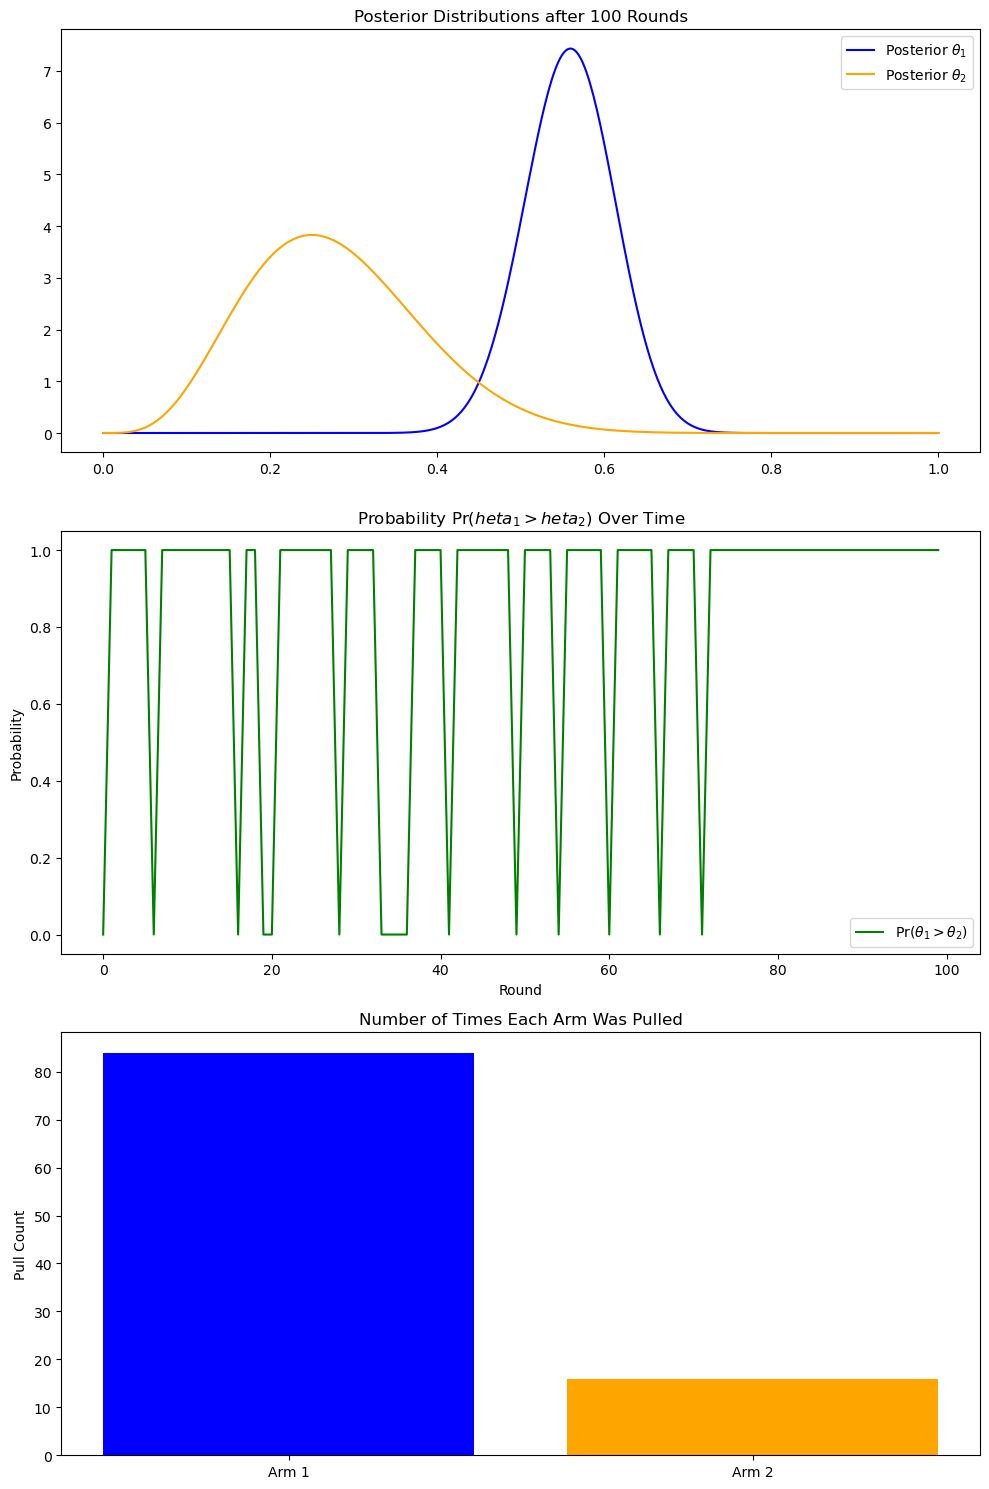

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

true_theta_1 = 0.6 
true_theta_2 = 0.4  
alpha_prior, beta_prior = 1, 1  

n_rounds = 100  
theta_1_posterior = [alpha_prior]
theta_2_posterior = [alpha_prior]
arm_pulls = [0, 0] 
rewards = [0, 0]  
prob_theta_1_greater = []

for t in range(n_rounds):
    
    sample_theta_1 = beta.rvs(theta_1_posterior[-1], beta_prior + arm_pulls[0] - rewards[0])
    sample_theta_2 = beta.rvs(theta_2_posterior[-1], beta_prior + arm_pulls[1] - rewards[1])
    
    
    prob_theta_1_greater.append(np.mean(sample_theta_1 > sample_theta_2))
    
    if sample_theta_1 > sample_theta_2:
        chosen_arm = 0
    else:
        chosen_arm = 1
    
    reward = np.random.binomial(1, true_theta_1 if chosen_arm == 0 else true_theta_2)
    
    if chosen_arm == 0:
        rewards[0] += reward
        arm_pulls[0] += 1
        theta_1_posterior.append(theta_1_posterior[-1] + reward)
    else:
        rewards[1] += reward
        arm_pulls[1] += 1
        theta_2_posterior.append(theta_2_posterior[-1] + reward)

final_theta_1 = (theta_1_posterior[-1], beta_prior + arm_pulls[0] - rewards[0])
final_theta_2 = (theta_2_posterior[-1], beta_prior + arm_pulls[1] - rewards[1])

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

x = np.linspace(0, 1, 500)
axs[0].plot(x, beta.pdf(x, *final_theta_1), label=r'Posterior $\theta_1$', color='blue')
axs[0].plot(x, beta.pdf(x, *final_theta_2), label=r'Posterior $\theta_2$', color='orange')
axs[0].set_title("Posterior Distributions after 100 Rounds")
axs[0].legend()

axs[1].plot(prob_theta_1_greater, label=r"$\Pr(\theta_1 > \theta_2)$", color='green')
axs[1].set_title("Probability $\Pr(\theta_1 > \theta_2)$ Over Time")
axs[1].set_xlabel("Round")
axs[1].set_ylabel("Probability")
axs[1].legend()

axs[2].bar(["Arm 1", "Arm 2"], arm_pulls, color=['blue', 'orange'])
axs[2].set_title("Number of Times Each Arm Was Pulled")
axs[2].set_ylabel("Pull Count")

plt.tight_layout()
plt.show()


## Q3


#### Analysis 1

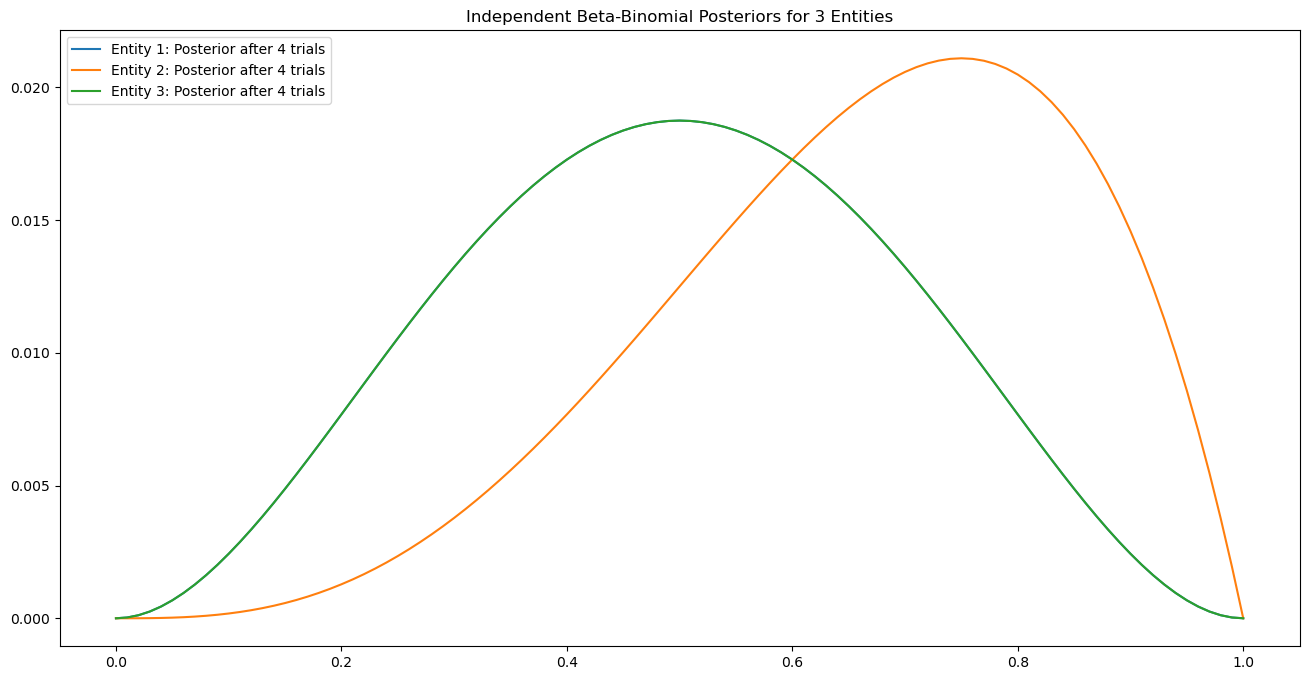

In [2]:
import numpy as np
from scipy.stats import beta 
import matplotlib.pyplot as plt

entities = 3
parameter_domain = np.linspace(0, 1, 101)
priors = [np.ones(101) / 101 for _ in range(entities)]  
observations = [[0, 1, 1, 0], [1, 1, 0, 1], [0, 0, 1, 1]]  
successes = [0] * entities
trials = [0] * entities

plt.figure(figsize=(16, 8))
for i, obs in enumerate(observations):
    for outcome in obs:
        trials[i] += 1
        successes[i] += outcome
        alpha_post = 1 + successes[i]
        beta_post = 1 + trials[i] - successes[i]
        posterior = beta.pdf(parameter_domain, alpha_post, beta_post)
        posterior /= posterior.sum()  
        priors[i] = posterior  
    plt.plot(parameter_domain, priors[i], label=f"Entity {i+1}: Posterior after {trials[i]} trials")

plt.title("Independent Beta-Binomial Posteriors for 3 Entities")
plt.legend()
plt.show()


#### Analysis 2

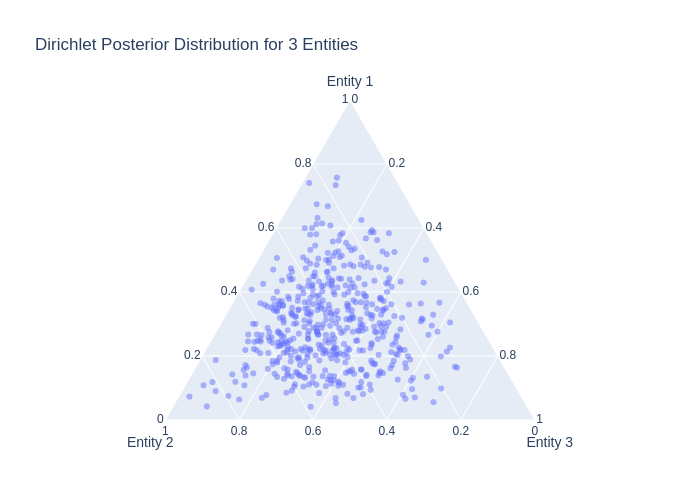

In [3]:
import numpy as np
import pandas as pd 
from scipy.stats import multinomial, dirichlet
import plotly.express as px

observations = [[0, 1, 1, 0], [1, 1, 0, 1], [0, 0, 1, 1]]
total_successes = [sum(obs) for obs in observations]

alpha_prior = [1, 1, 1]  
alpha_posterior = np.array(alpha_prior) + np.array(total_successes) 

dirichlet_samples = dirichlet.rvs(alpha_posterior, size=500)

df = pd.DataFrame(dirichlet_samples, columns=["Entity 1", "Entity 2", "Entity 3"])

fig = px.scatter_ternary(df, a="Entity 1", b="Entity 2", c="Entity 3", opacity=0.5,
                         title="Dirichlet Posterior Distribution for 3 Entities")
fig.show("png")


When comparing the two approaches, Analysis 1 (independent Beta-Binomial) is simple, interpretable, and makes no assumptions about relationships between entities. However, it ignores correlations and may over-explore when entities have similar success rates. Analysis 2 (Dirichlet-Multinomial) captures shared structures and efficiently balances exploration and exploitation but is more complex and relies on a suitable Dirichlet prior. In an A/B testing scenario for website designs, Analysis 1 suits drastically different designs (e.g., text-heavy vs. image-heavy). Analysis 2 is better for variations of a base design where conversion rates are likely related, leveraging shared information to improve inference. .